Based on: https://medium.com/howtoai/video-classification-with-cnn-rnn-and-pytorch-abe2f9ee031

In [1]:
import os
import numpy

path2original = "./data/original"
path2augmented = "./data/augmented"

original_fields = numpy.array(sorted(os.listdir(path2original)))

In [2]:
from torchvision.transforms.functional import to_pil_image

def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)        
    return x

Split the videos into two groups:

In [3]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
train_idx, test_idx = next(sss.split(original_fields))

train_original_fields = [original_fields[ind] for ind in train_idx]
test_original_fields = [original_fields[ind] for ind in test_idx]

augmented_fields = numpy.array(sorted(os.listdir(path2augmented)))

train_fields = [field for field in augmented_fields if field.startswith(tuple(train_original_fields))]
test_fields = [field for field in augmented_fields if field.startswith(tuple(test_original_fields))]

In [96]:
# Data set
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random

np.random.seed(2021)
random.seed(2021)
torch.manual_seed(2021)

def extractLabel(imageName):
    if "posev" in imageName:
        return 1
    elif "nothing" in imageName:
        return 0
    elif "posle" in imageName:
        return -1
    else:
        raise "No type found..."

class FieldsDataset(Dataset):
    def __init__(self, fields, transform, seq_length = 3, step = 1):
        self.transform = transform
        
        self.fields = fields

        self.sequences = []
        self.labels = []
        for field in fields:
            path = f'{path2augmented}/{field}/'
            #print(f'Processing field {field}')
            
            imageNames = []
            for root, dirs, files in os.walk(path):
                imageNames = sorted(files)
            
            # Remove "posle" images
            labelToMap = { name : extractLabel(name) for name in imageNames }
            imageNames = [name for name in imageNames if labelToMap[name] != -1 ]
            
            #print(imageNames)
            
            for i in range(0, len(imageNames), step):
                seqImageNames = []
                
                shouldBreak = False
                if (i >= len(imageNames) - seq_length):
                    shouldBreak = True
                    seqImageNames = imageNames[-seq_length:]
                else:
                    seqImageNames = imageNames[i : i + seq_length]

                label = 0
                if any(labelToMap[name] == 1 for name in seqImageNames):
                    label = 1
                self.labels.append(label)
                
                seqImagePaths = [path + name for name in seqImageNames]
                self.sequences.append(seqImagePaths);

                #print(f'Label {label}')
                #print(f'Pathes {seqImagePaths}')
                
                if shouldBreak:
                    break
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seqOfPaths = self.sequences[idx]

        frames = []
        for imagePath in seqOfPaths:
            frame = Image.open(imagePath).convert('RGB') # Converting to RGB to make sure the tensor of 3 layers
            frames.append(frame)
            
        seed = np.random.randint(1e9)
        frames_tr = []
        for ii, frame in enumerate(frames):
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
            
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)

        return frames_tr, self.labels[idx]

In [97]:
# Transformation

# Params

# choose one
model_type = "3dcnn"
#model_type = "rnn"

if model_type == "rnn":
    h, w =224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    h, w = 112, 112
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]

# Transforms

import torchvision.transforms as transforms

train_transformer = transforms.Compose([
        transforms.Resize((h,w)),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomAffine(degrees=0,
        #                        translate=(0.1,0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
])

In [98]:
# Create dataset
train_ds = FieldsDataset(fields= train_fields, transform= train_transformer)
print(len(train_ds))

1157


In [108]:
imgs, label = train_ds[7]
if len(imgs)>0:
    print(imgs.shape, torch.min(imgs), torch.max(imgs))

torch.Size([3, 3, 112, 112]) tensor(-0.5782) tensor(1.9399)


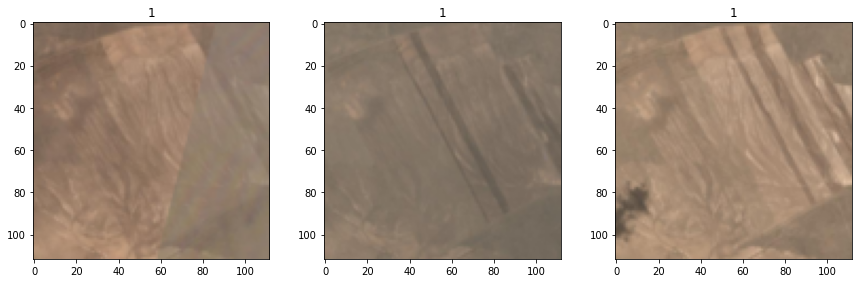

In [109]:
# Sample frames
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(20,20))
for ii,img in enumerate(imgs[:8]):
    plt.subplot(4,4,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

In [110]:
# Test data trasnform
test_transformer = transforms.Compose([
    transforms.Resize((h,w)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_ds = FieldsDataset(fields= test_fields, transform= test_transformer)
print(len(test_ds))

169


In [113]:
imgs, label = test_ds[3]
imgs.shape, torch.min(imgs), torch.max(imgs)

(torch.Size([3, 3, 112, 112]), tensor(-0.5240), tensor(1.6303))

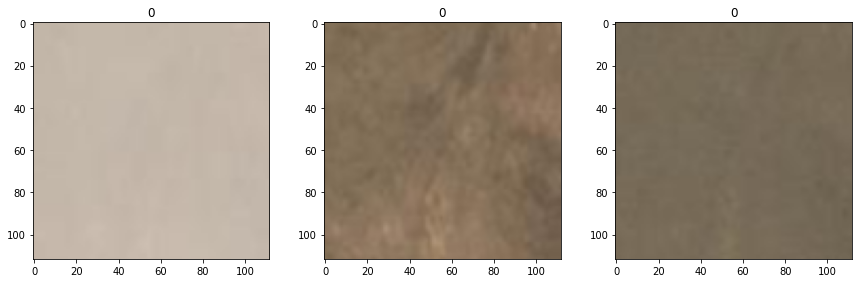

In [114]:
plt.figure(figsize=(20,20))
for ii,img in enumerate(imgs[:8]):
    plt.subplot(4,4,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

In [115]:
# Data Loaders

def collate_fn_3dcnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor
    

batch_size = 16
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True, collate_fn= collate_fn_rnn)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size, shuffle=False, collate_fn= collate_fn_rnn)
else:
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True, collate_fn= collate_fn_3dcnn)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size, shuffle=False, collate_fn=collate_fn_3dcnn)

In [116]:
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([16, 3, 3, 112, 112]) torch.Size([16])
